In [44]:
from typing import Callable, Any
import glob
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DATASET = "compas"
os.makedirs("plots", exist_ok=True)

In [45]:
formatting = {
    "risan": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN",
        "alpha": 0.4,
    },
    "risan g0": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN group 0",
        "alpha": 0.4,
    },
    "risan g1": {
        "color": "black",
        "linestyle": "--",
        "marker": "x",
        "label": "RISAN group 1",
        "alpha": 0.4,
    },
    "eq risan": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE RISAN",
        "alpha": 0.4,
    },
    "eq risan g0": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE RISAN group 0",
        "alpha": 0.4,
    },
    "eq risan g1": {
        "color": "blue",
        "linestyle": "--",
        "marker": "x",
        "label": "EQUISCALE RISAN group 1",
        "alpha": 0.4,
    },

    "kp1": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1",
        "alpha": 0.4,
    },
    "kp1 g0": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1 group 0",
        "alpha": 0.4,
    },
    "kp1 g1": {
        "color": "red",
        "linestyle": "--",
        "marker": "x",
        "label": "KP1 group 1",
        "alpha": 0.4,
    },
    "eq kp1": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE KP1",
        "alpha": 0.4,
    },
    "eq kp1 g0": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE KP1 group 0",
        "alpha": 0.4,
    },
    "eq kp1 g1": {
        "color": "darkorange",
        "linestyle": "--",
        "marker": "x",
        "label": "EQUISCALE KP1 group 1",
        "alpha": 0.4,
    },

    "dpabst": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST",
        "alpha": 0.4,
    },
    "dpabst g0": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST group 0",
        "alpha": 0.4,
    },
    "dpabst g1": {
        "color": "green",
        "linestyle": "--",
        "marker": "x",
        "label": "DPABST group 1",
        "alpha": 0.4,
    },
}

In [46]:
def plot_with_std(x_vals: pd.Series, y_vals: pd.Series, y_std: pd.Series, formatting):
    plot_kwargs = formatting.copy()
    del plot_kwargs["alpha"]
    fill_kwargs = formatting.copy()
    del fill_kwargs["label"]
    del fill_kwargs["marker"]
    plt.plot(x_vals, y_vals, **plot_kwargs)
    lower = ((y_vals - y_std).to_numpy()).clip(min=0, max=100)
    upper = ((y_vals + y_std).to_numpy()).clip(min=0, max=100)
    plt.fill_between(x_vals, lower, upper, **fill_kwargs)


def plot_without_std(x_vals, y_vals, formatting):
    plot_kwargs = formatting.copy()
    del plot_kwargs["alpha"]
    plt.plot(x_vals, y_vals, **plot_kwargs)

In [47]:
def plots(dataframes: dict[str, pd.DataFrame], metric: str, std: bool, groupwise: bool, diff: bool):
    for key in dataframes:
        if dataframes[key].empty:
            continue
        if std:
            if groupwise:
                plot_with_std(
                    dataframes[key]["cov_avg"],
                    dataframes[key][f"{metric}_0_avg"],
                    dataframes[key][f"{metric}_0_std"],
                    formatting[f"{key} g0"],
                )
                plot_with_std(
                    dataframes[key]["cov_avg"],
                    dataframes[key][f"{metric}_1_avg"],
                    dataframes[key][f"{metric}_1_std"],
                    formatting[f"{key} g1"],
                )
            else:
                plot_with_std(
                    dataframes[key]["cov_avg"],
                    dataframes[key][f"{metric}_avg"],
                    dataframes[key][f"{metric}_std"],
                    formatting[f"{key}"],
                )
        else: # Difference plots
            if diff:
                plot_without_std(
                    dataframes[key]["cov_avg"],
                    abs(dataframes[key][f"{metric}_0_avg"] - dataframes[key][f"{metric}_1_avg"]),
                    formatting[f"{key}"],
                )

In [48]:
def print_table(
    dataframes: dict[str, pd.DataFrame], metrics: list[str], agr: Callable[[Any], Any]
):
    entries = {"model": []}
    for metric in metrics:
        entries[metric] = []
    for key in dataframes.keys():
        if dataframes[key].empty:
            continue
        entries["model"].append(key)
        for metric in metrics:
            entries[metric].append(
                np.round(
                    agr(
                        np.abs(
                            dataframes[key][f"{metric}_0_avg"]
                            - dataframes[key][f"{metric}_1_avg"]
                        )
                    ),
                    2,
                )
            )
    df = pd.DataFrame.from_dict(entries)
    print(df)

# Independence section

In [ ]:
risan_pd = pd.DataFrame()
eq_risan_pd = pd.DataFrame()
kp1_pd = pd.DataFrame()
eq_kp1_pd = pd.DataFrame()
dpabst_pd = pd.DataFrame()

for file in glob.glob("results/*.json"):
    args = file.split("_")
    dataset = args[0].split("/")[1]
    if dataset != DATASET:
        continue
    model = args[2]
    fairness_conditions = args[1]
    record = {}
    with open(file, "r") as f:
            data = json.load(f)
    for key in data.keys():
        record[f"{key}_avg"] = round(data[key][0], 2)
        record[f"{key}_std"] = round(data[key][1], 2)
    temp = pd.Series(record).to_frame().T

    if model == "dpabst":
        dpabst_pd = pd.concat([dpabst_pd, temp])
    elif fairness_conditions == "none":
        if model == "risan":
            risan_pd = pd.concat([risan_pd, temp])
        else:
            kp1_pd = pd.concat([kp1_pd, temp])
    elif fairness_conditions == "abs-neg-pos":
        if model == "risan":
            eq_risan_pd = pd.concat([eq_risan_pd, temp])
        else:
            eq_kp1_pd = pd.concat([eq_kp1_pd, temp])
    else:
        continue #only normal and independence pd in this cell

dataframes: dict[str, pd.DataFrame] = {
    "risan": risan_pd,
    "eq risan": eq_risan_pd,
    "kp1": kp1_pd,
    "eq kp1": eq_kp1_pd,
    "dpabst": dpabst_pd,
}

for key in list(dataframes.keys()):
    if dataframes[key].empty:
        continue
    dataframes[key] = dataframes[key].sort_values(by="cov_avg")


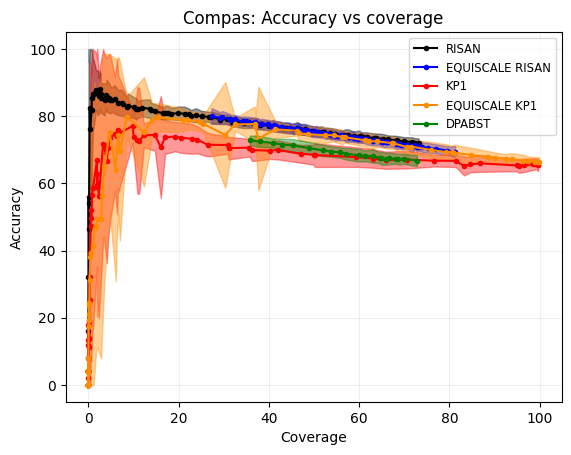

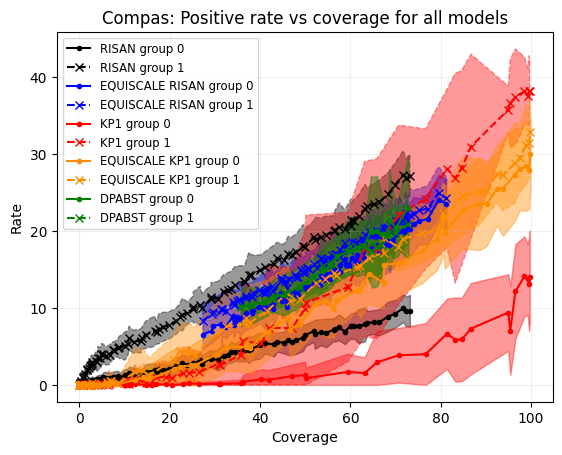

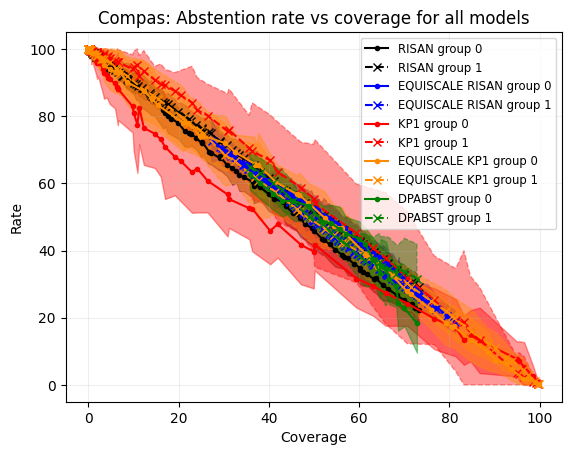

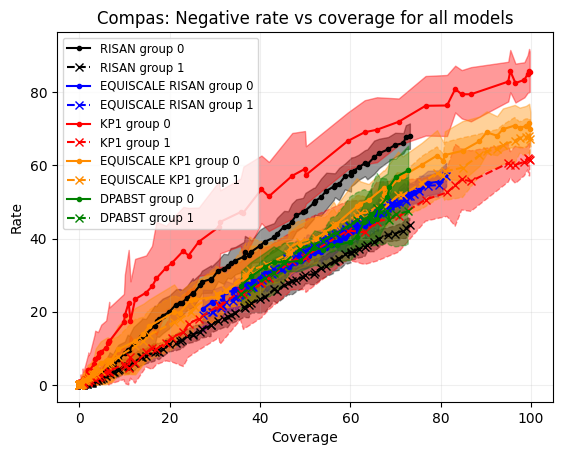

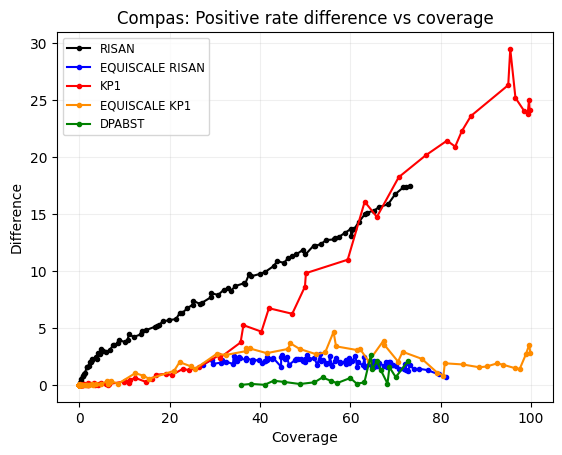

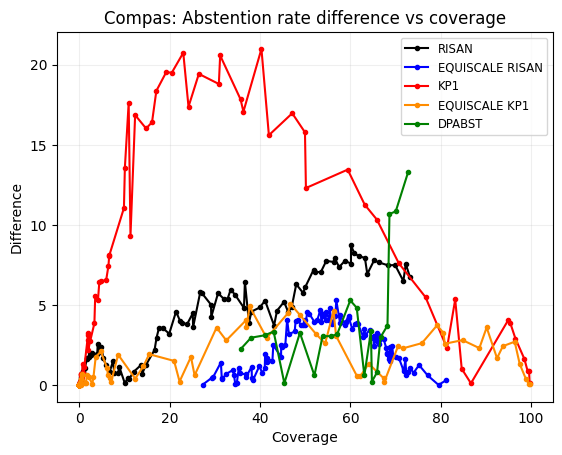

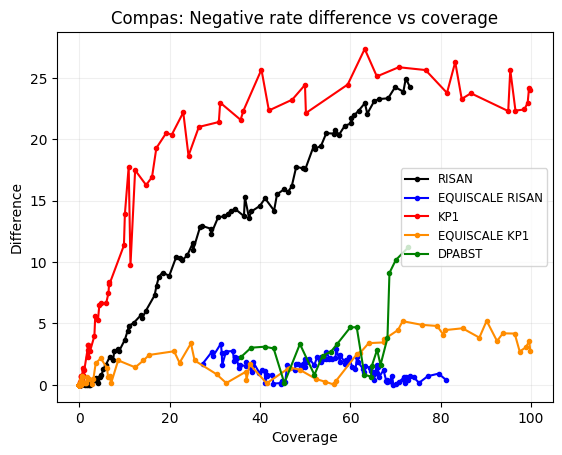

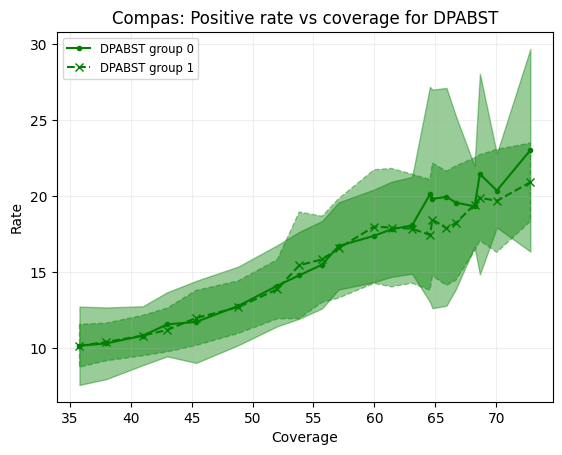

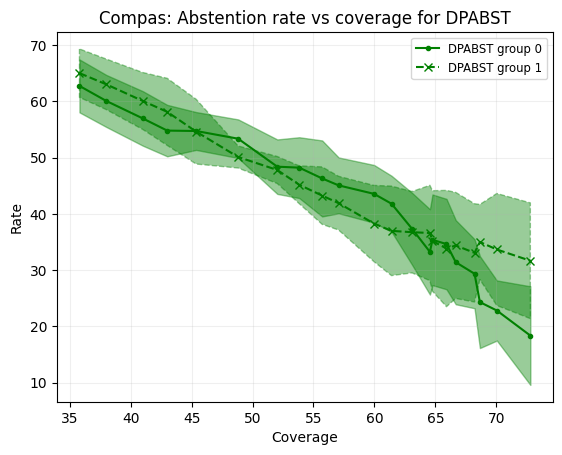

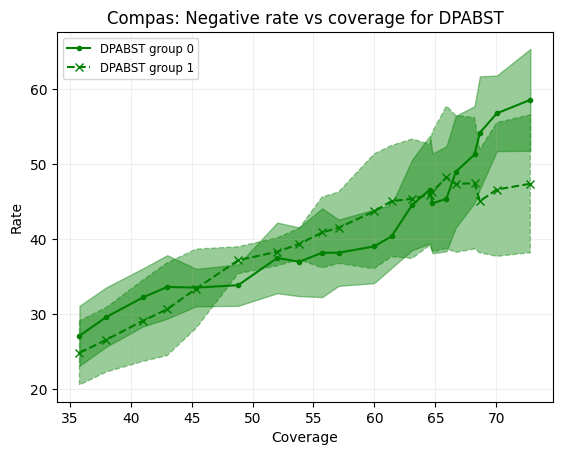

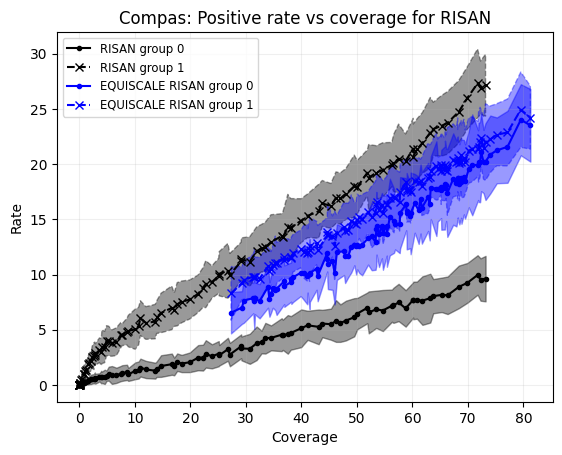

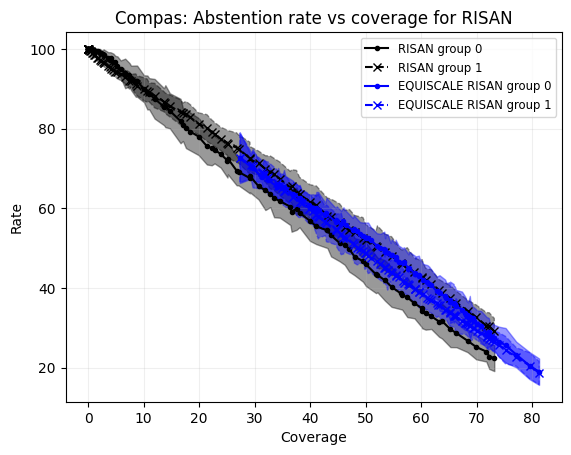

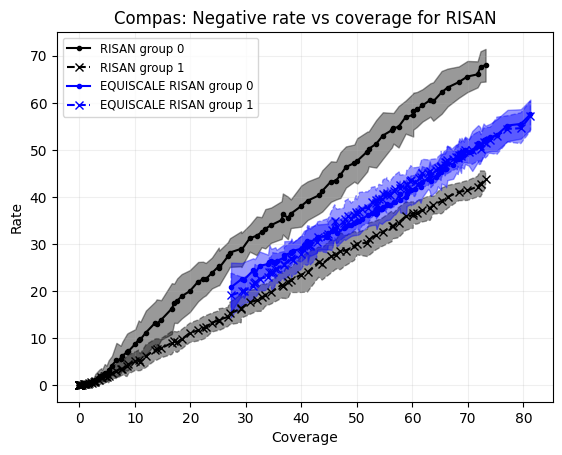

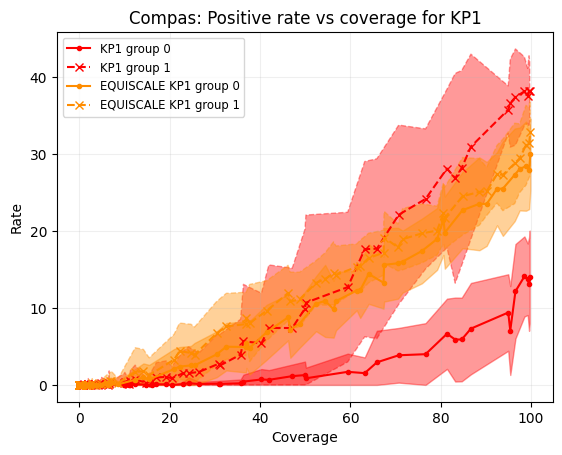

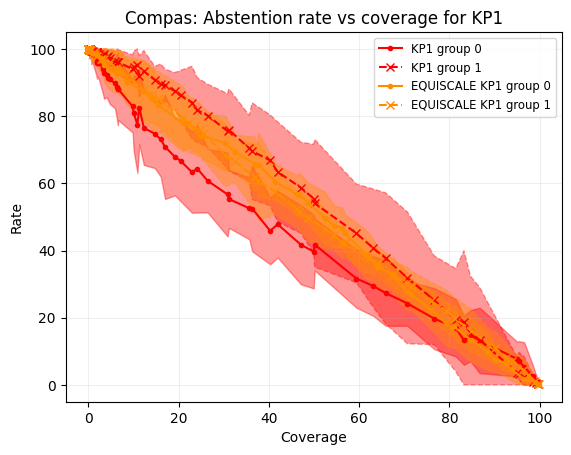

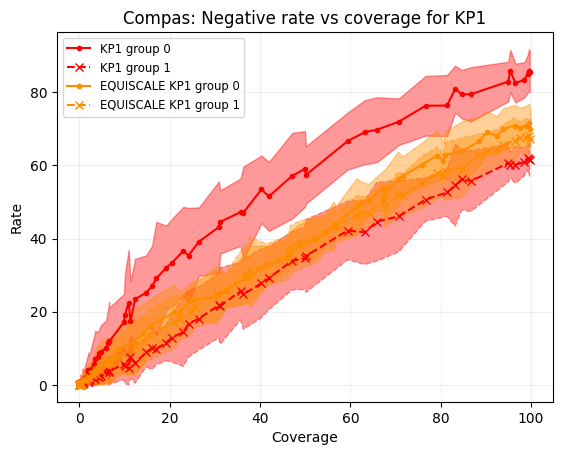

Average violation of fairness constraints
      model   pos   neg   abs
0     risan  6.79  9.69  3.63
1  eq risan  1.98  1.36  2.43
2       kp1  4.12  9.10  5.27
3    eq kp1  0.99  1.21  1.07
4    dpabst  0.72  3.59  3.88
Median violation of fairness constraints
      model   pos    neg   abs
0     risan  5.79  10.16  3.61
1  eq risan  1.98   1.44  2.45
2       kp1  0.02   2.83  1.01
3    eq kp1  0.03   0.26  0.21
4    dpabst  0.35   2.97  3.10
Max violation of fairness constriants
      model    pos    neg    abs
0     risan  17.52  24.94   8.71
1  eq risan   2.68   3.36   5.29
2       kp1  29.52  27.35  20.99
3    eq kp1   4.66   5.22   5.07
4    dpabst   2.67  11.19  13.30


In [ ]:
plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Accuracy vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.2)
plots(dataframes, "acc", True, False, False)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_acc")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots(dataframes, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_pos")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots(dataframes, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_abs")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots(dataframes, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_neg")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "pos", False, False, True)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_pos_delta")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "abs", False, False, True)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_abs_delta")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plt.grid(alpha=0.2)
plots(dataframes, "neg", False, False, True)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_neg_delta")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["dpabst"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_dpabst_pos")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["dpabst"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_dpabst_abs")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for DPABST")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["dpabst"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_dpabst_neg")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_risan_pos")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_risan_abs")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_risan_neg")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "pos", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_kp1_pos")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "abs", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_kp1_abs")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "neg", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_ind_kp1_neg")
plt.show()

print("Average violation of fairness constraints")
print_table(dataframes, ["pos", "neg", "abs"], np.average)
print("Median violation of fairness constraints")
print_table(dataframes, ["pos", "neg", "abs"], np.median)
print("Max violation of fairness constriants")
print_table(dataframes, ["pos", "neg", "abs"], np.max)

---

# Separation section

In [51]:
# Separation section
risan_pd = pd.DataFrame()
eq_risan_pd = pd.DataFrame()
kp1_pd = pd.DataFrame()
eq_kp1_pd = pd.DataFrame()

for file in glob.glob("results/*.json"):
    args = file.split("_")
    dataset = args[0].split("/")[1]
    if dataset != DATASET:
        continue
    model = args[2]
    fairness_conditions = args[1]
    record = {}
    with open(file, "r") as f:
            data = json.load(f)
    for key in data.keys():
        record[f"{key}_avg"] = round(data[key][0], 2)
        record[f"{key}_std"] = round(data[key][1], 2)
    temp = pd.Series(record).to_frame().T

    if model == "dpabst":
        continue
    elif fairness_conditions == "none":
        if model == "risan":
            risan_pd = pd.concat([risan_pd, temp])
        else:
            kp1_pd = pd.concat([kp1_pd, temp])
    elif fairness_conditions == "fnr-fpr-nar-par-tnr-tpr":
        if model == "risan":
            eq_risan_pd = pd.concat([eq_risan_pd, temp])
        else:
            eq_kp1_pd = pd.concat([eq_kp1_pd, temp])
    else:
        continue #only normal and separation pd in this cell

dataframes: dict[str, pd.DataFrame] = {
    "risan": risan_pd,
    "eq risan": eq_risan_pd,
    "kp1": kp1_pd,
    "eq kp1": eq_kp1_pd,
}

for key in list(dataframes.keys()):
    if dataframes[key].empty:
        continue
    dataframes[key] = dataframes[key].sort_values(by="cov_avg")


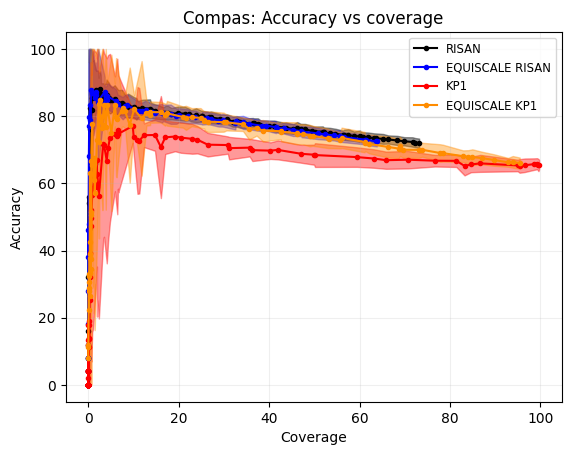

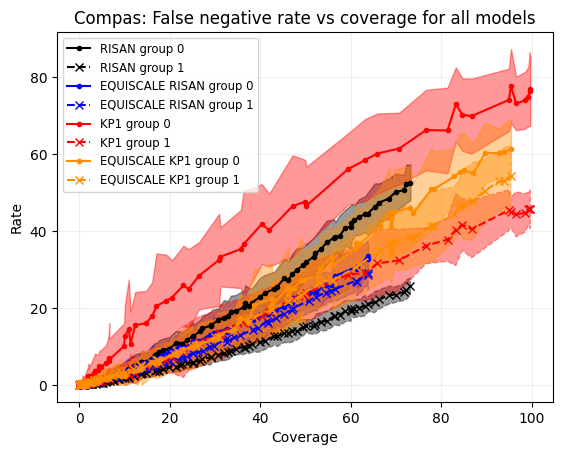

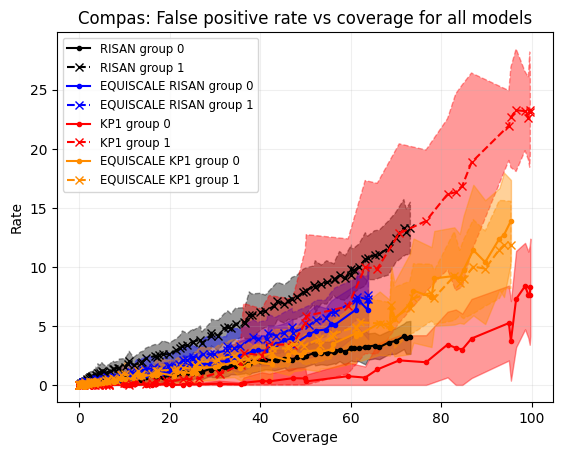

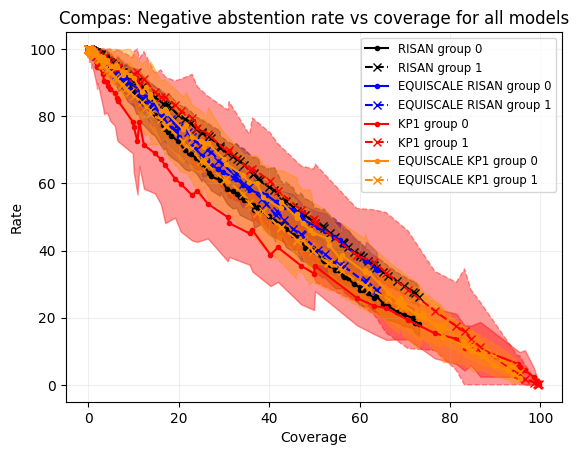

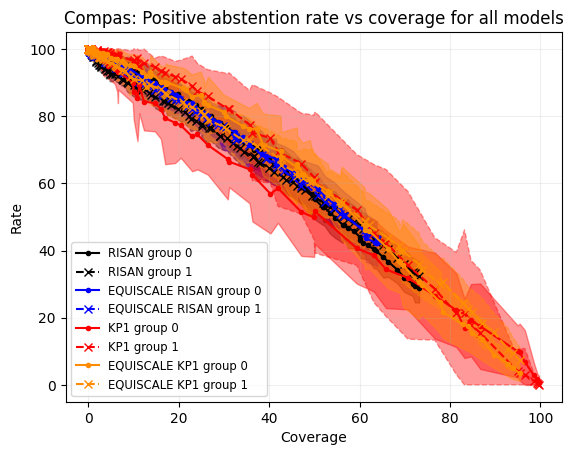

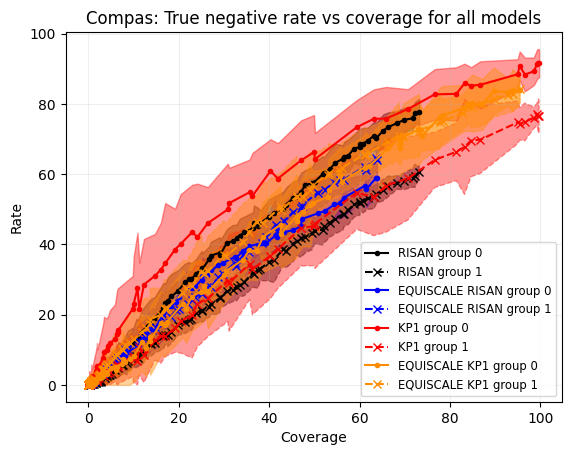

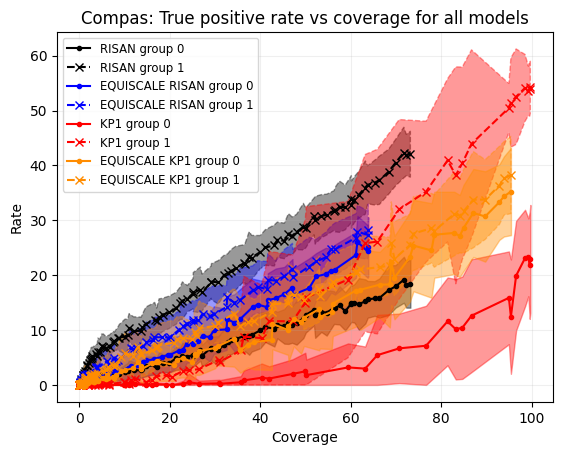

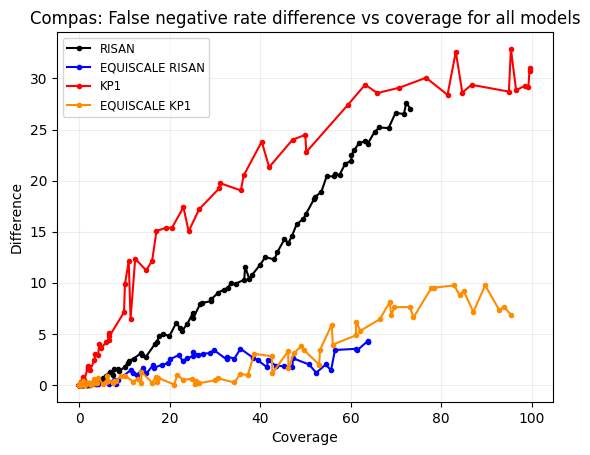

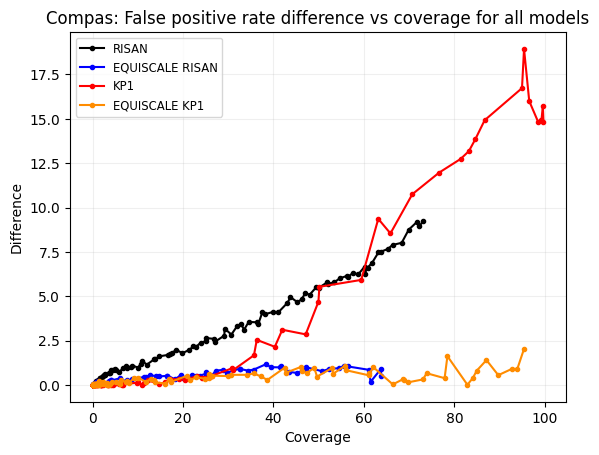

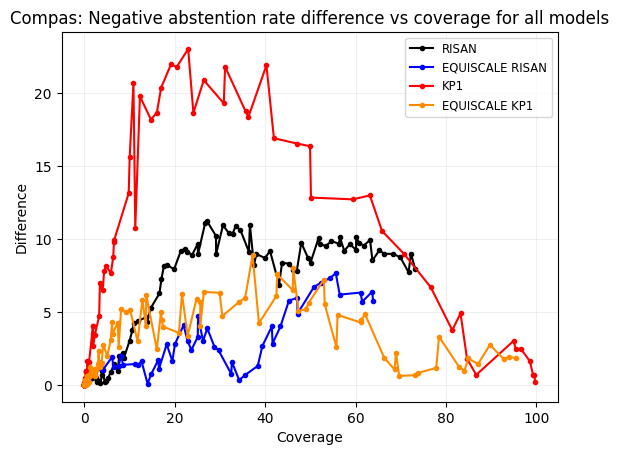

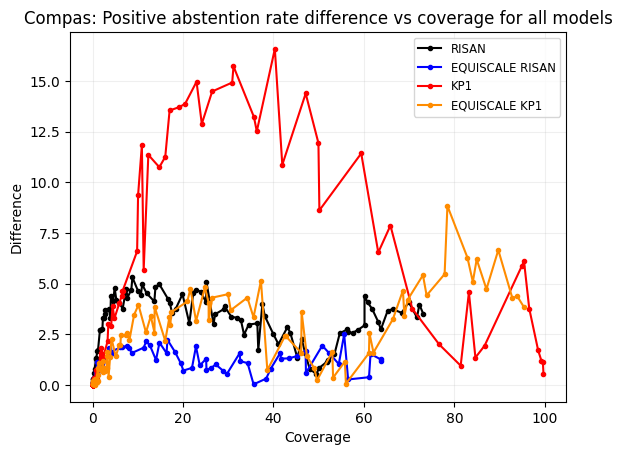

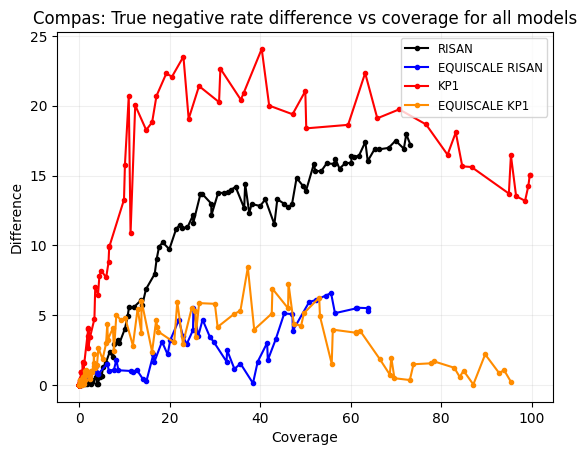

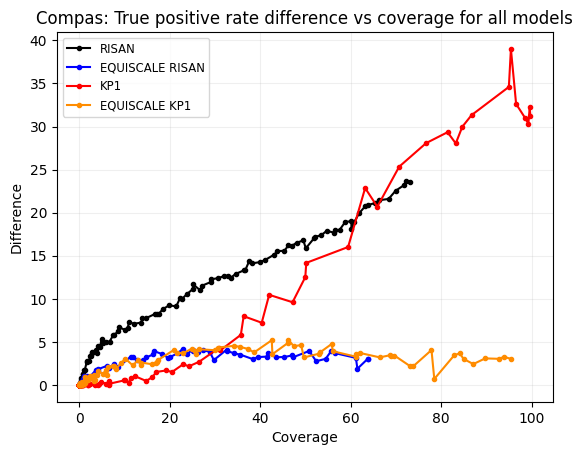

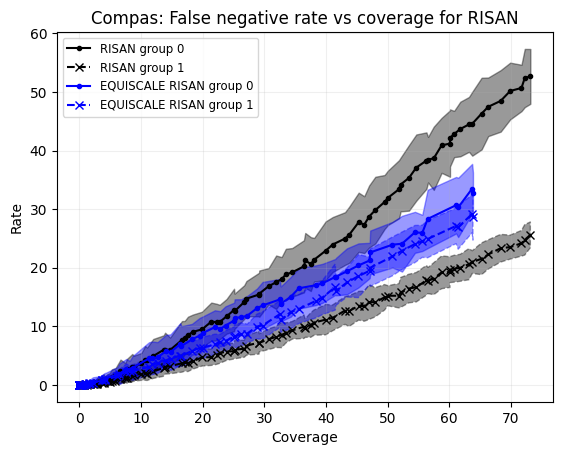

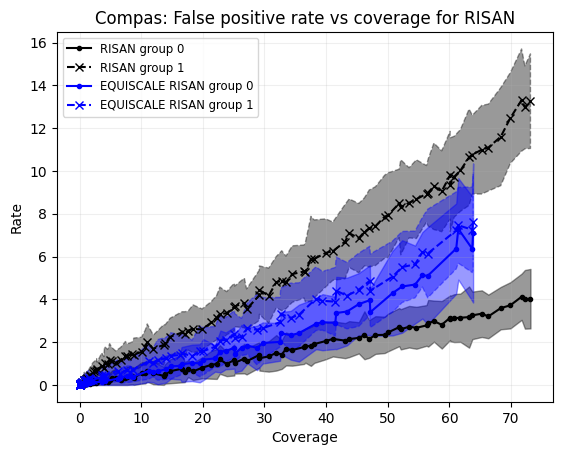

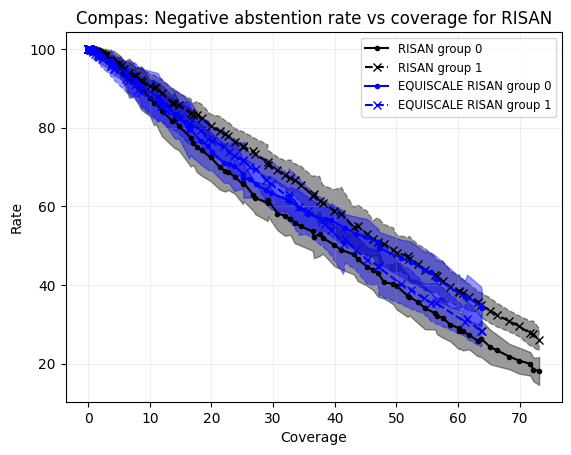

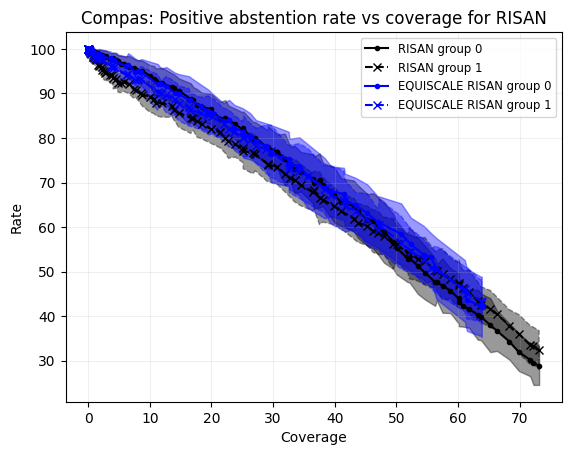

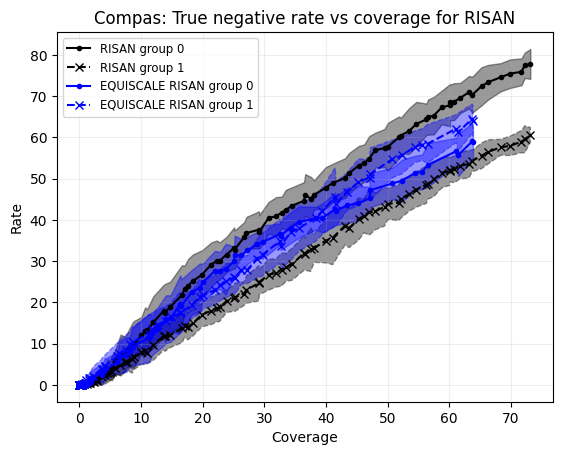

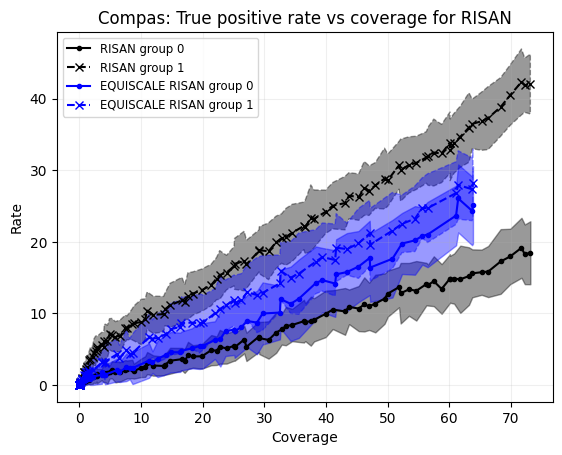

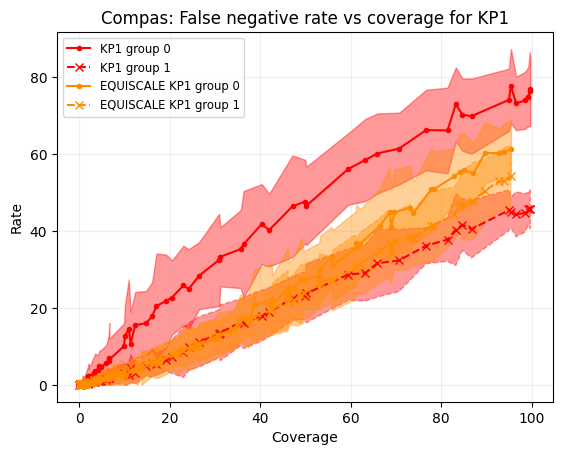

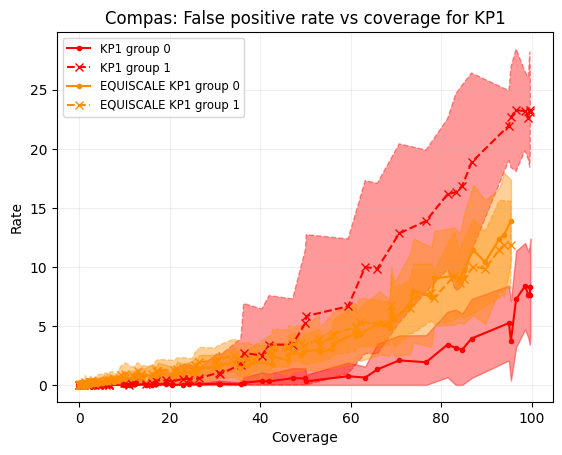

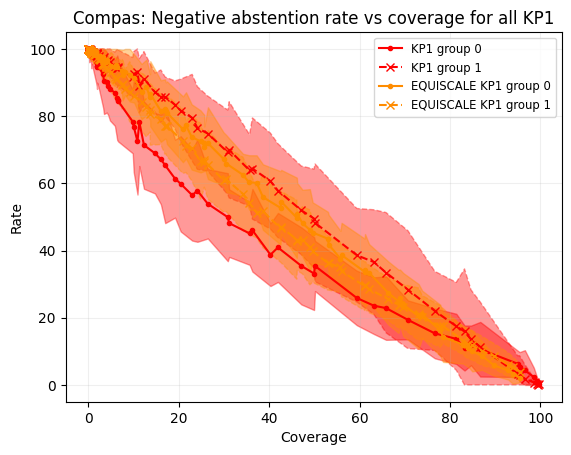

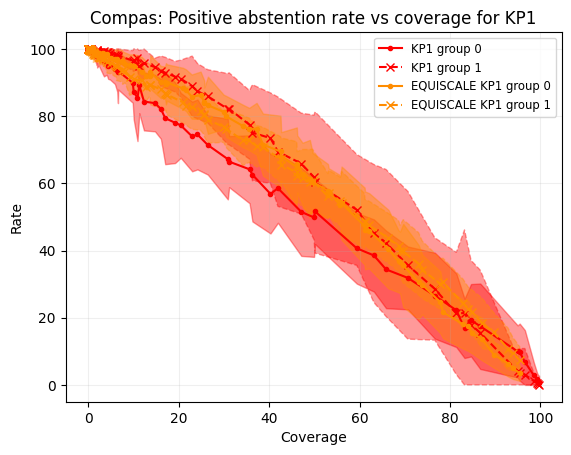

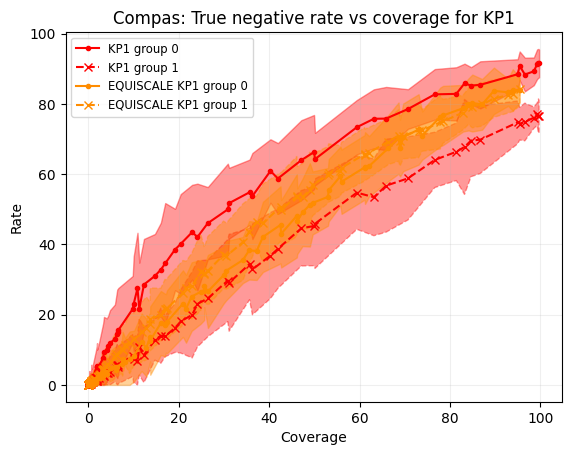

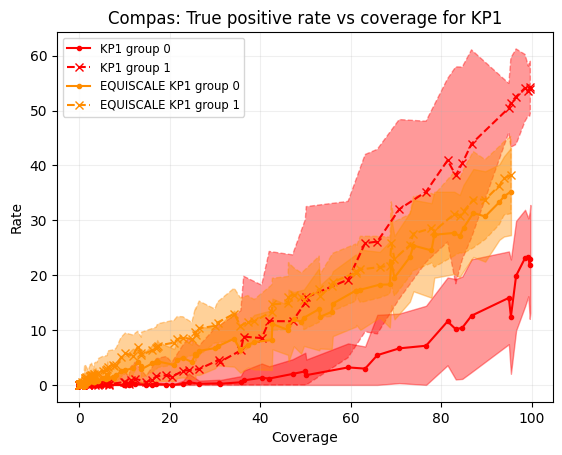

Average violation of fairness constraints
      model   fnr   fpr   nar   par   tnr   tpr
0     risan  8.41  2.90  5.57  2.86  8.35  9.96
1  eq risan  1.01  0.33  1.59  0.75  1.50  1.64
2       kp1  8.91  2.44  5.84  3.78  8.05  5.63
3    eq kp1  2.05  0.34  2.70  2.20  2.40  2.15
Median violation of fairness constraints
      model   fnr   fpr   nar   par    tnr   tpr
0     risan  5.32  1.99  7.89  3.29  11.18  9.25
1  eq risan  0.09  0.17  0.71  0.69   0.59  1.06
2       kp1  1.59  0.00  1.55  1.14   3.51  0.05
3    eq kp1  0.36  0.19  1.94  1.64   1.59  2.26
Max violation of fairness constriants
      model    fnr    fpr    nar    par    tnr    tpr
0     risan  27.61   9.23  11.26   5.31  17.96  23.63
1  eq risan   4.29   1.17   7.66   2.50   6.58   4.22
2       kp1  32.89  18.94  23.03  16.59  24.07  39.01
3    eq kp1   9.75   2.04   8.90   8.84   8.42   5.23


In [ ]:
plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Accuracy vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Accuracy")
plt.grid(alpha=0.2)
plots(dataframes, "acc", True, False, False)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_acc")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots(dataframes, "fnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_fnr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots(dataframes, "fpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_fpr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots(dataframes, "nar", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_nar")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive abstention rate vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots(dataframes, "par", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_par")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots(dataframes, "tnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_tnr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots(dataframes, "tpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_tpr")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plots(dataframes, "fnr", False, False, True)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_fnr_delta")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plots(dataframes, "fpr", False, False, True)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_fpr_delta")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plots(dataframes, "nar", False, False, True)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_nar_delta")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive abstention rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plots(dataframes, "par", False, False, True)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_par_delta")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plots(dataframes, "tnr", False, False, True)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_tnr_delta")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate difference vs coverage for all models")
plt.xlabel("Coverage")
plt.ylabel("Difference")
plots(dataframes, "tpr", False, False, True)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_tpr_delta")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "fnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_risan_fnr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "fpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_risan_fpr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "nar", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_risan_nar")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive abstention rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "par", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_risan_par")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "tnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_risan_tnr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for RISAN")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["risan", "eq risan"]}, "tpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_risan_tpr")
plt.show()


plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "fnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_kp1_fnr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: False positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "fpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_kp1_fpr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate vs coverage for all KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "nar", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_kp1_nar")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive abstention rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "par", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_kp1_par")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "tnr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_kp1_tnr")
plt.show()

plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for KP1")
plt.xlabel("Coverage")
plt.ylabel("Rate")
plots({k: dataframes[k] for k in ["kp1", "eq kp1"]}, "tpr", True, True, False)
plt.grid(alpha=0.2)
plt.legend(fontsize="small")
plt.savefig(f"plots/{DATASET}_sep_kp1_tpr")
plt.show()

print("Average violation of fairness constraints")
print_table(dataframes, ["fnr", "fpr", "nar", "par", "tnr", "tpr"], np.average)
print("Median violation of fairness constraints")
print_table(dataframes, ["fnr", "fpr", "nar", "par", "tnr", "tpr"], np.median)
print("Max violation of fairness constriants")
print_table(dataframes, ["fnr", "fpr", "nar", "par", "tnr", "tpr"], np.max)

---

# Mixed section

In [ ]:
formatting = {
    "risan ind": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN",
        "alpha": 0.4,
    },
    "risan ind g0": {
        "color": "black",
        "linestyle": "-",
        "marker": ".",
        "label": "RISAN group 0",
        "alpha": 0.4,
    },
    "risan ind g1": {
        "color": "black",
        "linestyle": "--",
        "marker": "x",
        "label": "RISAN group 1",
        "alpha": 0.4,
    },
    "risan sep": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE RISAN",
        "alpha": 0.4,
    },
    "risan sep g0": {
        "color": "blue",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE RISAN group 0",
        "alpha": 0.4,
    },
    "risan sep g1": {
        "color": "blue",
        "linestyle": "--",
        "marker": "x",
        "label": "EQUISCALE RISAN group 1",
        "alpha": 0.4,
    },

    "kp1 ind": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1",
        "alpha": 0.4,
    },
    "kp1 ind g0": {
        "color": "red",
        "linestyle": "-",
        "marker": ".",
        "label": "KP1 group 0",
        "alpha": 0.4,
    },
    "kp1 ind g1": {
        "color": "red",
        "linestyle": "--",
        "marker": "x",
        "label": "KP1 group 1",
        "alpha": 0.4,
    },
    "kp1 sep": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE KP1",
        "alpha": 0.4,
    },
    "kp1 sep g0": {
        "color": "darkorange",
        "linestyle": "-",
        "marker": ".",
        "label": "EQUISCALE KP1 group 0",
        "alpha": 0.4,
    },
    "kp1 sep g1": {
        "color": "darkorange",
        "linestyle": "--",
        "marker": "x",
        "label": "EQUISCALE KP1 group 1",
        "alpha": 0.4,
    },
    "dpabst": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST",
        "alpha": 0.4,
    },
    "dpabst g0": {
        "color": "green",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST group 0",
        "alpha": 0.4,
    },
    "dpabst g1": {
        "color": "green",
        "linestyle": "--",
        "marker": "x",
        "label": "DPABST group 1",
        "alpha": 0.4,
    },

    "risan mixed": {
        "color": "blueviolet",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST",
        "alpha": 0.4,
    },
    "risan mixed g0": {
        "color": "blueviolet",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST group 0",
        "alpha": 0.4,
    },
    "risan mixed g1": {
        "color": "blueviolet",
        "linestyle": "--",
        "marker": "x",
        "label": "DPABST group 1",
        "alpha": 0.4,
    },

    "kp1 mixed": {
        "color": "fuchsia",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST",
        "alpha": 0.4,
    },
    "kp1 mixed g0": {
        "color": "fuchsia",
        "linestyle": "-",
        "marker": ".",
        "label": "DPABST group 0",
        "alpha": 0.4,
    },
    "kp1 mixed g1": {
        "color": "fuchsia",
        "linestyle": "--",
        "marker": "x",
        "label": "DPABST group 1",
        "alpha": 0.4,
    },
}

In [ ]:
# Mixed section
# load dpabst, eq ind, eq sep, and eq mixed

risan_ind_pd = pd.DataFrame()
risan_sep_pd = pd.DataFrame()
risan_mixed_pd = pd.DataFrame()
kp1_ind_pd = pd.DataFrame()
kp1_sep_pd = pd.DataFrame()
kp1_mixed_pd = pd.DataFrame()
dpabst_pd = pd.DataFrame()

for file in glob.glob("results/*.json"):
    args = file.split("_")
    dataset = args[0].split("/")[1]
    if dataset != DATASET:
        continue
    model = args[2]
    fairness_conditions = args[1]
    record = {}
    with open(file, "r") as f:
        data = json.load(f)
    for key in data.keys():
        record[f"{key}_avg"] = round(data[key][0], 2)
        record[f"{key}_std"] = round(data[key][1], 2)
    temp = pd.Series(record).to_frame().T

    if model == "dpabst":
        dpabst_pd = pd.concat([dpabst_pd, temp])
    elif fairness_conditions == "none":
        continue
    elif fairness_conditions == "abs-neg-pos":
        if model == "risan":
            eq_risan_pd = pd.concat([risan_ind_pd, temp])
        else:
            eq_kp1_pd = pd.concat([kp1_ind_pd, temp])
    elif fairness_conditions == "fnr-fpr-nar-par-tnr-tpr":
        if model == "risan":
            eq_risan_pd = pd.concat([risan_sep_pd, temp])
        else:
            eq_kp1_pd = pd.concat([kp1_sep_pd, temp])
    else:
        if model == "risan":
            eq_risan_pd = pd.concat([risan_mixed_pd, temp])
        else:
            eq_kp1_pd = pd.concat([kp1_mixed_pd, temp])


dataframes: dict[str, pd.DataFrame] = {
    "risan ind": risan_ind_pd,
    "risan sep": risan_sep_pd,
    "risan mixed": risan_mixed_pd,
    "kp1 ind": kp1_ind_pd,
    "kp1 sep": kp1_sep_pd,
    "kp1 mixed": kp1_mixed_pd,
    "dpabst": dpabst_pd,
}

for key in list(dataframes.keys()):
    if dataframes[key].empty:
        continue
    dataframes[key] = dataframes[key].sort_values(by="cov_avg")

In [ ]:
if DATASET == "adult": # pos, abs, neg, tpr
    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Accuracy vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.2)
    plots(dataframes, "acc", True, False, False)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_acc")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots(dataframes, "pos", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_pos")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots(dataframes, "abs", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_abs")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots(dataframes, "neg", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_neg")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate difference vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Difference")
    plt.grid(alpha=0.2)
    plots(dataframes, "pos", False, False, True)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_pos_delta")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate difference vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Difference")
    plt.grid(alpha=0.2)
    plots(dataframes, "abs", False, False, True)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_abs_delta")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate difference vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Difference")
    plt.grid(alpha=0.2)
    plots(dataframes, "neg", False, False, True)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_neg_delta")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for RISAN")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["risan ind", "risan sep", "risan mixed"]}, "pos", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_risan_pos")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for RISAN")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["risan ind", "risan sep", "risan mixed"]}, "abs", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_risan_abs")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for RISAN")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["risan ind", "risan sep", "risan mixed"]}, "neg", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_risan_neg")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for KP1")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["kp1 ind", "kp1 sep", "kp1 mixed"]}, "pos", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_kp1_pos")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Abstention rate vs coverage for KP1")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["kp1 ind", "kp1 sep", "kp1 mixed"]}, "abs", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_kp1_abs")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative rate vs coverage for KP1")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["kp1 ind", "kp1 sep", "kp1 mixed"]}, "neg", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_kp1_neg")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots(dataframes, "tpr", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_tpr")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate difference vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Difference")
    plots(dataframes, "tpr", False, False, True)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_tpr_delta")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for RISAN")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["risan ind", "risan sep", "risan mixed"]}, "tpr", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_risan_tpr")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True positive rate vs coverage for KP1")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["kp1 ind", "kp1 sep", "kp1 mixed"]}, "tpr", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_kp1_tpr")
    plt.show()

    print("Average violation of fairness constraints")
    print_table(dataframes, ["pos", "neg", "abs", "tpr"], np.average)
    print("Median violation of fairness constraints")
    print_table(dataframes, ["pos", "neg", "abs", "tpr"], np.median)
    print("Max violation of fairness constriants")
    print_table(dataframes, ["pos", "neg", "abs", "tpr"], np.max)

In [ ]:
if DATASET == "german": # pos, tnr, nar
    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Accuracy vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.2)
    plots(dataframes, "acc", True, False, False)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_acc")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots(dataframes, "pos", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_pos")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate difference vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Difference")
    plt.grid(alpha=0.2)
    plots(dataframes, "pos", False, False, True)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_pos_delta")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for RISAN")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["risan ind", "risan sep", "risan mixed"]}, "pos", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_risan_pos")
    plt.show()


    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Positive rate vs coverage for KP1")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["kp1 ind", "kp1 sep", "kp1 mixed"]}, "pos", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_kp1_pos")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots(dataframes, "tnr", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_tnr")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate difference vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Difference")
    plots(dataframes, "tnr", False, False, True)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_tnr_delta")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots(dataframes, "nar", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_nar")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate difference vs coverage for all models")
    plt.xlabel("Coverage")
    plt.ylabel("Difference")
    plots(dataframes, "nar", False, False, True)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_nar_delta")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for RISAN")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["risan ind", "risan sep", "risan mixed"]}, "tnr", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_risan_tnr")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: True negative rate vs coverage for KP1")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["kp1 ind", "kp1 sep", "kp1 mixed"]}, "tnr", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_kp1_tnr")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate vs coverage for RISAN")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["risan ind", "risan sep", "risan mixed"]}, "nar", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_risan_nar")
    plt.show()

    plt.title(f"{DATASET[0].upper() + DATASET[1:]}: Negative abstention rate vs coverage for KP1")
    plt.xlabel("Coverage")
    plt.ylabel("Rate")
    plots({k: dataframes[k] for k in ["kp1 ind", "kp1 sep", "kp1 mixed"]}, "nar", True, True, False)
    plt.grid(alpha=0.2)
    plt.legend(fontsize="small")
    plt.savefig(f"plots/{DATASET}_mixed_kp1_nar")
    plt.show()


    print("Average violation of fairness constraints")
    print_table(dataframes, ["pos", "tnr", "nar"], np.average)
    print("Median violation of fairness constraints")
    print_table(dataframes, ["pos", "tnr", "nar"], np.median)
    print("Max violation of fairness constriants")
    print_table(dataframes, ["pos", "tnr", "nar"], np.max)